In [1]:
# List containing disease names
list_of_classes = ['Black Rot', 'ESCA', 'Leaf Blight', 'Healthy']
batch_size = 16

In [2]:
import numpy as np # Linear algebra
import pandas as pd # Tabular data
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # High-level data visualization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Object containing data
from tensorflow.keras import Sequential # Model containing layers
from tensorflow.keras import Input # Input layer
from tensorflow.keras.layers import * # All other layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Executed after each epoch
from tensorflow.keras.losses import SparseCategoricalCrossentropy # Loss for categorical data
from tensorflow.keras.applications import * # Importing all model architectures
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

Found 10200 images belonging to 4 classes.
Found 1800 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.
{'Black Rot': 0, 'ESCA': 1, 'Leaf Blight': 2, 'Healthy': 3}
{'Black Rot': 0, 'ESCA': 1, 'Leaf Blight': 2, 'Healthy': 3}
{'Black Rot': 0, 'ESCA': 1, 'Leaf Blight': 2, 'Healthy': 3}
Label: 3.0


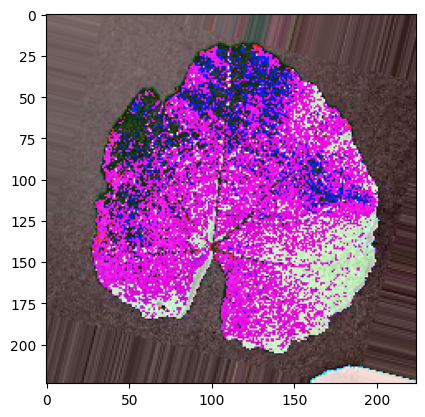

Label: 0.0


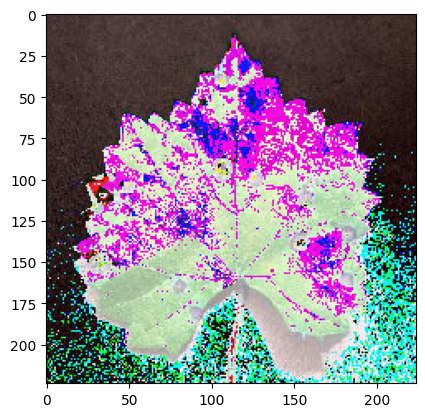

Label: 3.0


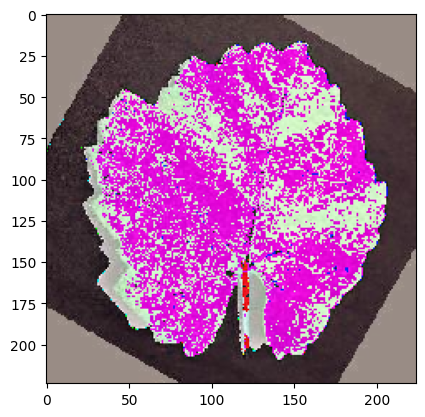

Label: 0.0


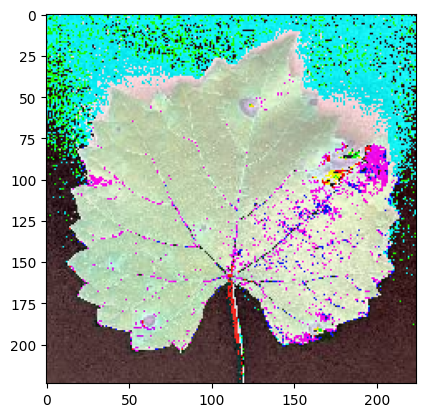

Label: 3.0


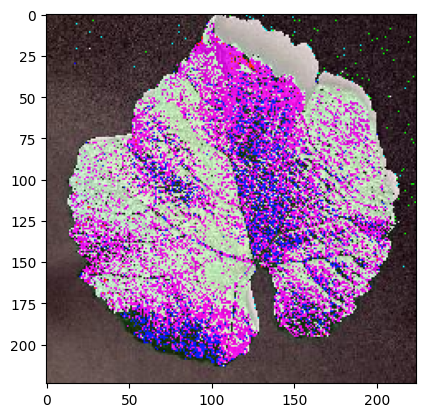

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to normalize images (scale pixel values to [0, 1])
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Apply normalization to the data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Final Training Data',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    classes=list_of_classes,
    shuffle=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Validation Data',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    classes=list_of_classes,
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Test Data',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    classes=list_of_classes,
    shuffle=False
)

# Print the class indices to check the class mapping
print(train_datagen.class_indices)
print(validation_datagen.class_indices)
print(test_datagen.class_indices)

# Display some normalized images to verify
for _ in range(5):
    img, label = next(train_datagen)
    plt.imshow(img[0].astype('uint8'))
    print("Label:", label[0])
    plt.savefig('/kaggle/working/processing.png', format='png', dpi=300)
    plt.show()


In [4]:
# Function to plot training and validation accuracy/loss curves
def plot_training_history(history, model_name):
    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/kaggle/working/accuracy.png', format='png', dpi=300)
    plt.show()
    
    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/kaggle/working/loss.png', format='png', dpi=300)
    plt.show()


In [5]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, test_data, class_labels):
    # Get true and predicted labels
    true_labels = test_data.classes
    pred_probs = model.predict(test_data)
    pred_labels = np.argmax(pred_probs, axis=-1)

    # Print classification report
    report = classification_report(true_labels, pred_labels, target_names=class_labels)
    print("Classification Report:\n", report)
    
    # Binarize the true labels for multi-class AUC
    true_binarized = label_binarize(true_labels, classes=range(len(class_labels)))
    
    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(true_binarized[:, i], pred_probs[:, i])
        auc_score = roc_auc_score(true_binarized[:, i], pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('/kaggle/working/AoC.png', format='png', dpi=300)
    plt.show()

    # Display some correct and incorrect predictions
    display_predictions(test_data, true_labels, pred_labels, class_labels)
    
    # Return values for further analysis if needed
    return pred_labels, true_labels


def display_predictions(test_data, true_labels, pred_labels, class_labels):
    """
    Display examples of correct and incorrect predictions.
    """
    # Get filenames from test data
    filenames = test_data.filepaths
    
    # Indices of correct and incorrect predictions
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]
    
    # Plot correct predictions
    print("Correct Predictions:")
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(correct_indices[:5]):  # Display up to 5 samples
        img = plt.imread(filenames[idx])
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_labels[idx]]}\nPred: {class_labels[pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/correct_preds.png', format='png', dpi=300)
    plt.show()

    # Plot incorrect predictions
    print("Incorrect Predictions:")
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(incorrect_indices[:5]):  # Display up to 5 samples
        img = plt.imread(filenames[idx])
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_labels[idx]]}\nPred: {class_labels[pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/incorrect_preds.png', format='png', dpi=300)
    plt.show()


In [6]:
# Define the function to build a model using ResNet50
def build_resnet50_model(input_shape, num_classes):
    # Load the ResNet50 base model with pretrained weights (ImageNet) excluding top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers (initial training only for top layers)
    base_model.trainable = False
    
    # Create a new model on top of the pretrained base
    model = Sequential([
        base_model,  # Pretrained base model
        GlobalAveragePooling2D(),  # Global average pooling layer
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer
        BatchNormalization(),
        Dropout(0.6),  # Dropout for regularization
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer
        BatchNormalization(),
        Dropout(0.6),  # Dropout for regularization
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))  # Output layer
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

    return model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734325322.073966      90 service.cc:145] XLA service 0x7b22800025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734325322.074042      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/638 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.2292 - loss: 9.0479   

I0000 00:00:1734325329.736552      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


638/638 ━━━━━━━━━━━━━━━━━━━━ 91s 119ms/step - accuracy: 0.8247 - loss: 4.2192 - val_accuracy: 0.9894 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 2/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9519 - loss: 0.9315 - val_accuracy: 0.9861 - val_loss: 0.5063 - learning_rate: 0.0010
Epoch 3/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9517 - loss: 0.5453 - val_accuracy: 0.9928 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 4/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.9514 - loss: 0.4608 - val_accuracy: 0.9906 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 5/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9540 - loss: 0.4107 - val_accuracy: 0.9744 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 6/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9553 - loss: 0.3953 - val_accuracy: 0.9800 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 7/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.9562 - loss:

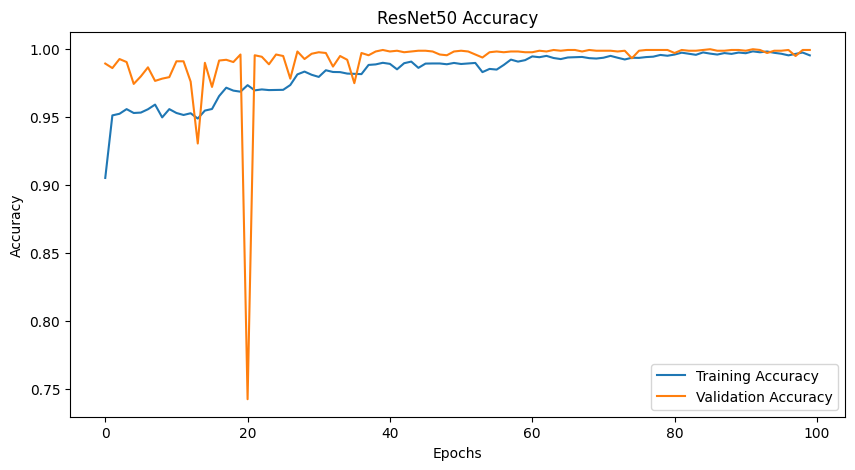

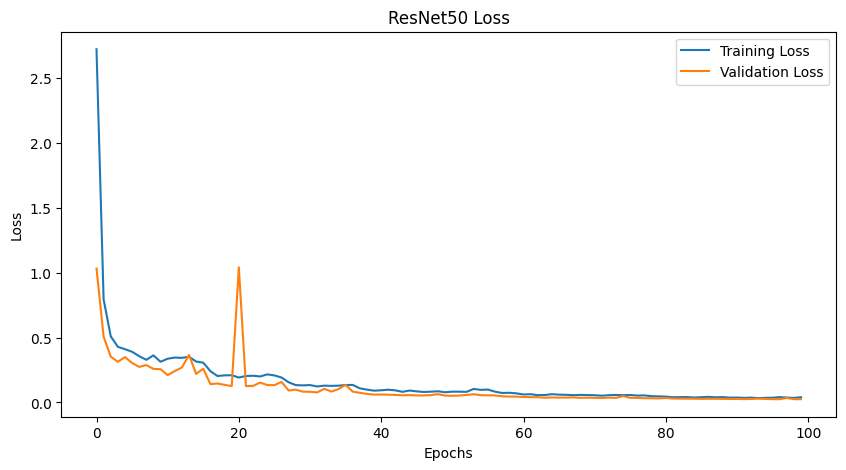

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step
Classification Report:
               precision    recall  f1-score   support

   Black Rot       1.00      0.99      0.99       472
        ESCA       0.99      1.00      0.99       480
 Leaf Blight       1.00      1.00      1.00       430
     Healthy       1.00      1.00      1.00       423

    accuracy                           1.00      1805
   macro avg       1.00      1.00      1.00      1805
weighted avg       1.00      1.00      1.00      1805



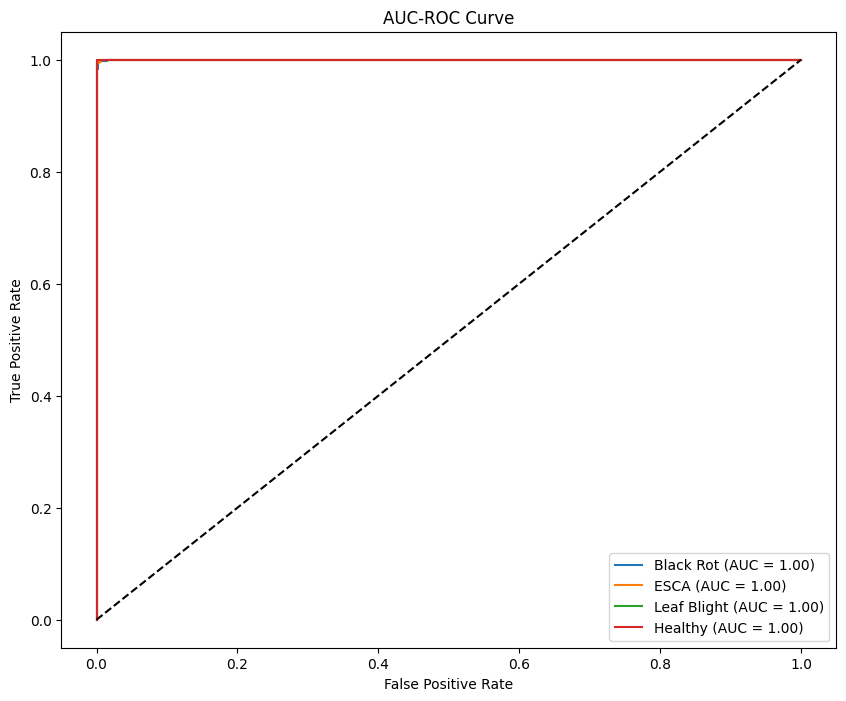

Correct Predictions:


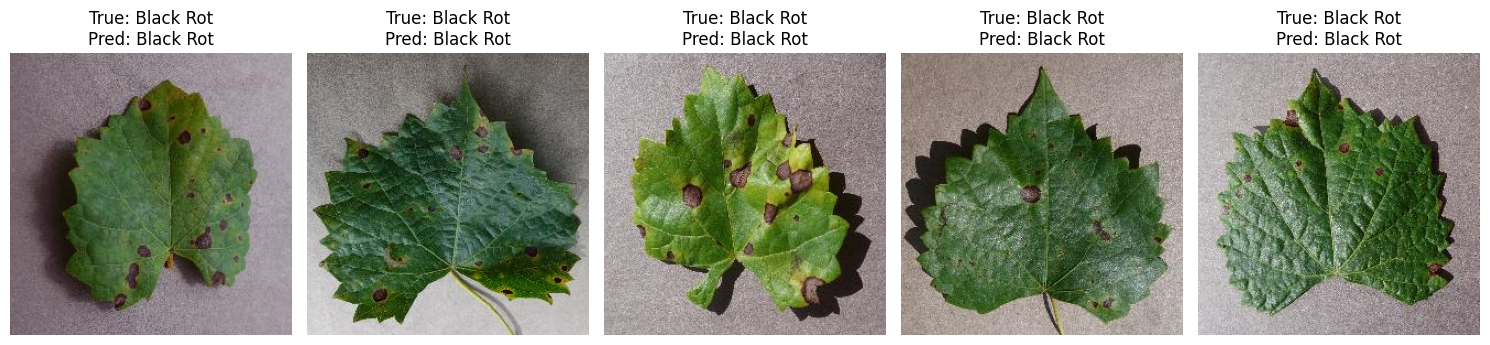

Incorrect Predictions:


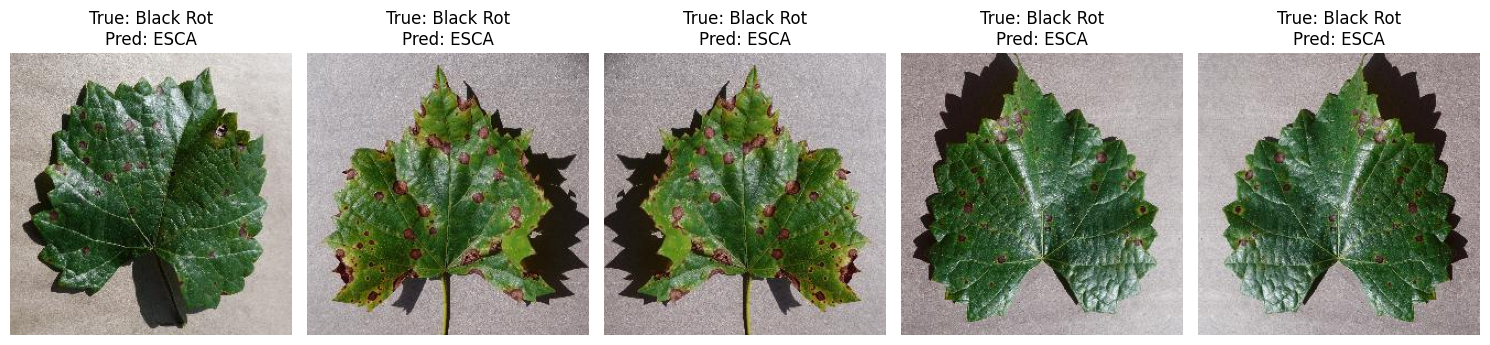

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Model parameters
input_shape = (224, 224, 3)  # Image dimensions
num_classes = 4  # Total number of classes

# Build the ResNet50-based model
resnet50_model = build_resnet50_model(input_shape=input_shape, num_classes=num_classes)

# Print model summary
resnet50_model.summary()

# Define callbacks
resnet50_callbacks = [
    # Dynamic learning rate adjustment
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    
    # Early stopping
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
    
    # Model checkpoint to save best model based on validation accuracy
    ModelCheckpoint('/kaggle/working/resnet50_best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')
]

# Train the ResNet50 model
history_resnet50 = resnet50_model.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=100,
    callbacks=resnet50_callbacks
)

# Plot accuracy and loss curves for training and validation
plot_training_history(history_resnet50, model_name="ResNet50")

# Evaluate and report on the test data
pred_labels_resnet50, true_labels_resnet50 = evaluate_and_plot(resnet50_model, test_datagen, list_of_classes)

# Save the model
resnet50_model.save("resnet50_model.h5")


In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model_path = "/kaggle/working/resnet50_model.h5"  # Update path if different
model = load_model(model_path)

# Class labels
class_labels = ['Black Rot', 'ESCA', 'Leaf Blight', 'Healthy']

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesses the image for prediction.
    
    Args:
        image_path (str): Path to the image.
        target_size (tuple): Target size for resizing the image.
    
    Returns:
        np.array: Preprocessed image ready for the model.
    """
    img = load_img(image_path, target_size=target_size)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to classify the image
def classify_image(model, image_path):
    """
    Classifies an input image using the trained model.
    
    Args:
        model: Trained Keras model.
        image_path (str): Path to the image to be classified.
    
    Returns:
        str: Predicted class label.
    """
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = class_labels[np.argmax(predictions)]
    
    # Show the image with prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
    
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


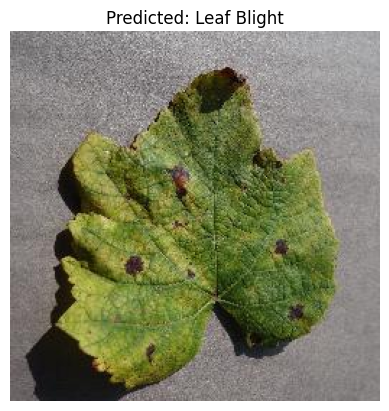

Predicted Class: Leaf Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


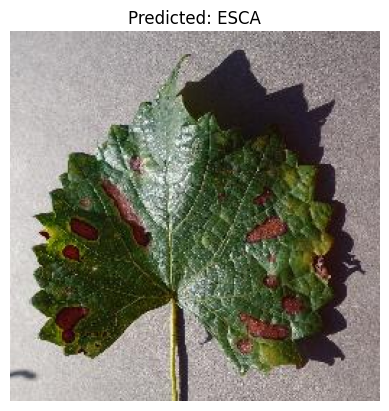

Predicted Class: ESCA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


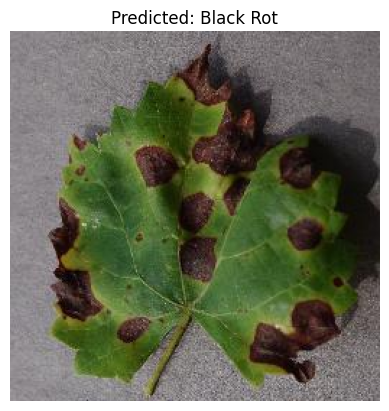

Predicted Class: Black Rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


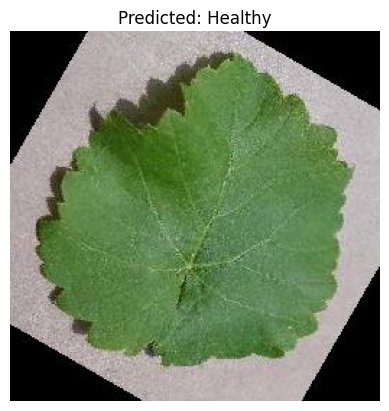

Predicted Class: Healthy


In [9]:
image_path = "/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Test Data/Leaf Blight/165a404c-f7a8-475b-850e-f60b37f49b8c___FAM_L.Blight 3710_flipLR.JPG"  # Replace with your image path
predicted_label = classify_image(model, image_path)
print("Predicted Class:", predicted_label)

image_path = "/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Test Data/ESCA/143f0875-9844-410b-853c-cd8f6a918e63___FAM_B.Msls 3897.JPG"  # Replace with your image path
predicted_label = classify_image(model, image_path)
print("Predicted Class:", predicted_label)

image_path = "/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Test Data/Black Rot/0563d959-cdc8-4e5f-be50-aff6238218be___FAM_B.Rot 3600_flipLR.JPG"  # Replace with your image path
predicted_label = classify_image(model, image_path)
print("Predicted Class:", predicted_label)

image_path = "/kaggle/input/grape-vine-leaf-disease/Folder Augmented/Test Data/Healthy/0ca59865-f0d2-4863-b4d1-a6690de53a5a___Mt.N.V_HL 6025_new30degFlipLR.JPG"  # Replace with your image path
predicted_label = classify_image(model, image_path)
print("Predicted Class:", predicted_label)

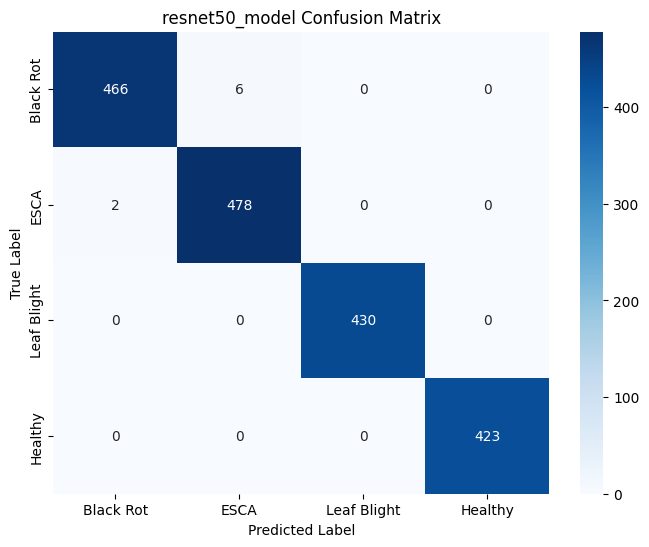

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model_name, true_labels, pred_labels, class_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig('/kaggle/working/subplots_image.png', format='png', dpi=300)
    plt.show()

plot_confusion_matrix("resnet50_model", true_labels_resnet50, pred_labels_resnet50, list_of_classes)